In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append("../../")


from src.DatasetManager import DatasetConvertor 
from src.context_free.config import ModelConfig, TrainingConfig, DatasetConfig
from src.context_free.preprocessing import PreparingDataset
from src.context_free.models import createModel
from src.context_free.training import trainModel
from src.context_free.evaluation import evaluateModel

In [2]:
rawDatasetFolder = "../../data/raw"

verbose = True
mapping = {"forward": "fr", "backward": "bk"}
dpdr_params = [
    {"dbParameter": 0.01, "alpha": 0.01, "mode": "fixed"}
]

direction = "forward"
datasetConverter = DatasetConvertor(rawDatasetFolder)
datasetConverter.processDataset(direction=direction, **dpdr_params[0])
thumbDataUnit = datasetConverter.getDataUnit(f"thumb_{mapping[direction]}")

========== Thumb ============
Forward: Compression rate: 0.2231
========== Index ============
Forward: Compression rate: 0.2456
========== Middle ============
Forward: Compression rate: 0.2491


In [8]:
lenWindow = 30
lenSource = 10
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, len_source=lenSource, data_augment=True)
trainData, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)
(sources, targets) = trainData
print(sources.shape)
print(targets.shape)

(62051, 10, 1)
(62051, 1, 1)


In [9]:
# Match model dims to dataset feature sizes
modelConfig = ModelConfig()
model, device = createModel(modelConfig)

In [10]:
# Reduce training load to avoid OOM/errors
trainingConfig = TrainingConfig()
best_model, avg_train_loss_history, avg_test_loss_history = trainModel(
    model, trainData, testData, trainingConfig, verbose=verbose
)

Size of train loader: 8, Size of test loader: 6
Size of model: 1324289
Seq2Seq(
  (encoder): Encoder(
    (lstm_layers): ModuleList(
      (0): LSTM(1, 128, bidirectional=True)
      (1): LSTM(256, 128, bidirectional=True)
    )
    (ln_layers): ModuleList(
      (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): Identity()
    )
  )
  (decoder): Decoder(
    (lstm_layers): ModuleList(
      (0): LSTM(1, 256)
      (1): LSTM(256, 256)
    )
    (ln_layers): ModuleList(
      (0-1): 2 x LayerNorm((256,), eps=1e-05, elementwise_affine=True)
    )
    (residual_projections): ModuleList(
      (0): Linear(in_features=1, out_features=256, bias=True)
      (1): Identity()
    )
    (fc_out): Linear(in_features=256, out_features=1, bias=True)
  )
)
Epoch [1/30], Train Loss: 31.118538, Validation Loss: 13.773459
Epoch [2/30], Train Loss: 14.964558, Validation Los

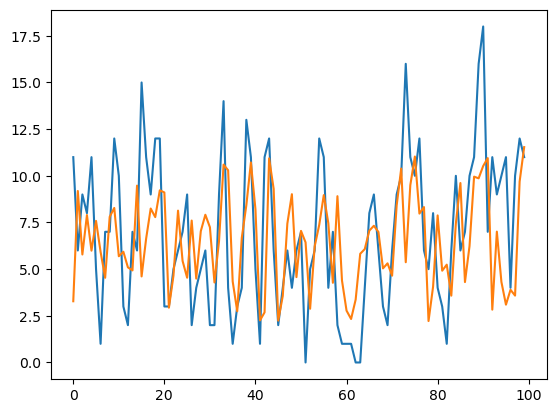

In [11]:
datasetConfig = DatasetConfig.initialize(len_window=lenWindow, len_source=lenSource, data_augment=False)
_, testData = PreparingDataset(thumbDataUnit, datasetConfig, verbose=False)
traffic_predictor, device = createModel(modelConfig)
traffic_predictor.load_state_dict(best_model)
actual, predicted = evaluateModel(traffic_predictor, testData)

plt.plot(actual[0:100])
plt.plot(predicted[0:100])
plt.show()